# ============================================
# NOTEBOOK: 03_shap_analysis.ipynb
# OBJETIVO: Análisis de interpretabilidad con SHAP
# AUTOR: [Tu nombre]
# FECHA: [Fecha actual]
# ============================================

# # 🔍 Interpretabilidad con SHAP
# 
# ## Objetivo
# Entender **por qué** el modelo hace las predicciones que hace
# 
# ## Contenido
# 1. Cargar modelo entrenado
# 2. Configurar SHAP TreeExplainer
# 3. Calcular SHAP values
# 4. Visualizaciones clave:
#    - Waterfall Plot (explicación individual)
#    - Summary Plot (importancia global)
#    - Dependence Plot (relaciones)
# 5. Análisis de casos específicos
# 6. Insights de interpretabilidad

In [8]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# SHAP - Interpretabilidad
import shap

# Guardar/Cargar modelos
import joblib
from pathlib import Path

# Configuración
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Inicializar JavaScript para visualizaciones SHAP interactivas
shap.initjs()

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


In [10]:
# ## 2. Cargar Datos y Modelo

# Cargar datos (mismo proceso que notebook 02)

# Nombres de las columnas
column_names = [
    'checking_status', 'duration', 'credit_history', 'purpose', 
    'credit_amount', 'savings_status', 'employment', 'installment_rate',
    'personal_status', 'other_parties', 'residence_since', 
    'property_magnitude', 'age', 'other_payment_plans', 'housing',
    'existing_credits', 'job', 'num_dependents', 'own_telephone',
    'foreign_worker', 'risk'
]

# Cargar dataset
df = pd.read_csv('../../german_credit_data/german.data', 
                 sep=' ',
                 header=None,
                 names=column_names)

# Convertir target
df['risk'] = df['risk'].map({1: 0, 2: 1})

print("✅ Datos cargados")
print(f"📊 Dimensiones: {df.shape}")

✅ Datos cargados
📊 Dimensiones: (1000, 21)


In [11]:
# Separar features y target
X = df.drop('risk', axis=1)
y = df['risk']

# Identificar tipos de variables
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\n📊 Variables numéricas: {len(numeric_features)}")
print(f"📝 Variables categóricas: {len(categorical_features)}")

# %%
# Encoding de variables categóricas
X_encoded = X.copy()
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col])
    label_encoders[col] = le

print("✅ Encoding completado")

# %%
# Split train/test (mismo que en entrenamiento)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, 
    y, 
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"✅ Split completado: {X_train.shape[0]} train, {X_test.shape[0]} test")



📊 Variables numéricas: 7
📝 Variables categóricas: 13
✅ Encoding completado
✅ Split completado: 800 train, 200 test


In [12]:
# Cargar modelo entrenado
model_path = Path('../models/xgboost_model.pkl')

if model_path.exists():
    model = joblib.load(model_path)
    print("✅ Modelo cargado correctamente")
    print(f"📋 Hiperparámetros del modelo:")
    print(f"  - n_estimators: {model.n_estimators}")
    print(f"  - max_depth: {model.max_depth}")
    print(f"  - learning_rate: {model.learning_rate}")
else:
    print("❌ Modelo no encontrado. Ejecuta notebook 02 primero.")
    raise FileNotFoundError("Modelo no existe en /models")

✅ Modelo cargado correctamente
📋 Hiperparámetros del modelo:
  - n_estimators: 200
  - max_depth: 3
  - learning_rate: 0.05


In [13]:
# ## 3. Configurar SHAP TreeExplainer

print("="*60)
print("🚀 CONFIGURACIÓN DE SHAP")
print("="*60)

# Crear explainer
# TreeExplainer es óptimo para XGBoost (muy rápido)
explainer = shap.TreeExplainer(model)

print("✅ SHAP TreeExplainer creado")

# Manejo robusto del expected_value (puede ser array, list, o escalar)
print(f"\n🔍 Tipo de expected_value: {type(explainer.expected_value)}")

# Convertir a numpy array si es necesario
expected_val = np.array(explainer.expected_value)

# Si es array, tomar el valor para clase 1 (Bad Risk)
if expected_val.ndim > 0 and len(expected_val) > 1:
    base_value = float(expected_val[1])  # Clase 1 (Bad)
    print(f"📊 Expected value es un array con {len(expected_val)} valores")
    print(f"   - Clase 0 (Good): {expected_val[0]:.4f}")
    print(f"   - Clase 1 (Bad):  {expected_val[1]:.4f}")
    print(f"\n✅ Usando base_value para clase Bad: {base_value:.4f}")
else:
    base_value = float(expected_val)
    print(f"📊 Expected value (baseline): {base_value:.4f}")

print("\n💡 Expected value = predicción promedio sin información del cliente")
print(f"   En promedio, el modelo predice {base_value:.1%} de probabilidad de Bad Risk")

🚀 CONFIGURACIÓN DE SHAP
✅ SHAP TreeExplainer creado

🔍 Tipo de expected_value: <class 'numpy.ndarray'>
📊 Expected value (baseline): 0.0000

💡 Expected value = predicción promedio sin información del cliente
   En promedio, el modelo predice 0.0% de probabilidad de Bad Risk


In [14]:
 ## 4. Calcular SHAP Values

# %%
print("\n⏳ Calculando SHAP values para test set...")

# Calcular SHAP values
# Nota: Para 200 muestras tarda ~10-20 segundos
shap_values = explainer.shap_values(X_test)

print("✅ SHAP values calculados")
print(f"📊 Shape: {shap_values.shape}")
print(f"   - {shap_values.shape[0]} muestras (test set)")
print(f"   - {shap_values.shape[1]} features")



⏳ Calculando SHAP values para test set...
✅ SHAP values calculados
📊 Shape: (200, 20)
   - 200 muestras (test set)
   - 20 features


# ### Verificación Matemática Crítica
# 
# **Propiedad fundamental de SHAP:**
# ```
# sum(SHAP values) + expected_value = predicción del modelo
# ```

In [17]:
print("\n" + "="*60)
print("🔍 VERIFICACIÓN MATEMÁTICA DE SHAP")
print("="*60)

# Seleccionar una muestra aleatoria
sample_idx = 0

# Obtener componentes
base_value = explainer.expected_value
shap_sum = shap_values[sample_idx].sum()
prediction_logit = model.predict(X_test.iloc[[sample_idx]], output_margin=True)[0]

print(f"\nMuestra #{sample_idx}:")
print(f"  1. Base value (baseline):     {base_value:.6f}")
print(f"  2. Sum de SHAP values:        {shap_sum:.6f}")
print(f"  3. Base + Sum:                {base_value + shap_sum:.6f}")
print(f"  4. Predicción real (logit):   {prediction_logit:.6f}")

# Verificar que sean casi iguales (diferencias por redondeo)
difference = abs((base_value + shap_sum) - prediction_logit)
print(f"\n  Diferencia: {difference:.8f}")

if difference < 0.01:
    print("  ✅ VERIFICACIÓN EXITOSA: SHAP values suman correctamente")
else:
    print("  ⚠️ Verificación con diferencia mayor a esperada")


🔍 VERIFICACIÓN MATEMÁTICA DE SHAP

Muestra #0:
  1. Base value (baseline):     0.000180
  2. Sum de SHAP values:        -0.363633
  3. Base + Sum:                -0.363453
  4. Predicción real (logit):   -0.363453

  Diferencia: 0.00000006
  ✅ VERIFICACIÓN EXITOSA: SHAP values suman correctamente


# ## 5. Visualización 1: WATERFALL PLOT (Explicación Individual)
# 
# **¿Qué muestra?**
# - Contribución de cada feature para UNA predicción específica
# - Cómo se construye la predicción paso a paso



🌊 WATERFALL PLOT - EXPLICACIÓN INDIVIDUAL

👤 CLIENTE #0:
  Predicción: Good Risk (0)
  Probabilidad de Bad: 41.0%
  Real: Good Risk (0)


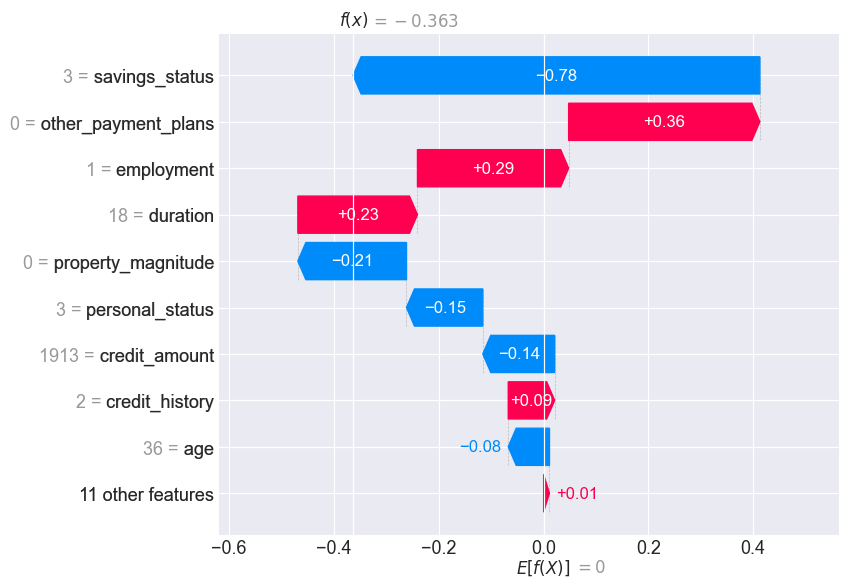

In [18]:
print("\n" + "="*60)
print("🌊 WATERFALL PLOT - EXPLICACIÓN INDIVIDUAL")
print("="*60)

# Seleccionar un cliente del test set
cliente_idx = 0

# Información del cliente
print(f"\n👤 CLIENTE #{cliente_idx}:")
print(f"  Predicción: {'Bad Risk (1)' if model.predict(X_test.iloc[[cliente_idx]])[0] == 1 else 'Good Risk (0)'}")
print(f"  Probabilidad de Bad: {model.predict_proba(X_test.iloc[[cliente_idx]])[0][1]:.1%}")
print(f"  Real: {'Bad Risk (1)' if y_test.iloc[cliente_idx] == 1 else 'Good Risk (0)'}")

# Crear waterfall plot
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[cliente_idx],
        base_values=explainer.expected_value,
        data=X_test.iloc[cliente_idx],
        feature_names=X_test.columns.tolist()
    )
)

# ### 📖 Cómo Interpretar el Waterfall Plot:
# 
# 1. **E[f(x)]** = Expected value (baseline) = Predicción promedio sin información
# 2. **Barras rojas** (hacia arriba) = Aumentan riesgo (empujan hacia Bad)
# 3. **Barras azules** (hacia abajo) = Disminuyen riesgo (empujan hacia Good)
# 4. **f(x)** = Predicción final
# 
# **Las features están ordenadas por importancia (impacto)**


In [19]:
# Explicación en lenguaje natural
def generate_natural_explanation(shap_vals, feature_names, base_value, threshold=0.01):
    """
    Genera explicación en lenguaje natural de los SHAP values
    
    Parámetros:
    -----------
    shap_vals : array
        SHAP values de una muestra
    feature_names : list
        Nombres de las features
    base_value : float
        Expected value (baseline)
    threshold : float
        Umbral mínimo de impacto para mencionar
    """
    # Crear DataFrame con features y sus SHAP values
    shap_df = pd.DataFrame({
        'feature': feature_names,
        'shap_value': shap_vals,
        'abs_shap': np.abs(shap_vals)
    }).sort_values('abs_shap', ascending=False)
    
    # Filtrar features con impacto significativo
    significant = shap_df[shap_df['abs_shap'] > threshold].head(5)
    
    # Generar explicación
    explanation = "### 📝 Explicación en Lenguaje Natural:\n\n"
    explanation += f"**Baseline de riesgo:** {base_value:.1%} (promedio sin información)\n\n"
    explanation += "**Factores que influyen en esta decisión:**\n\n"
    
    for idx, row in significant.iterrows():
        feature = row['feature']
        impact = row['shap_value']
        direction = "AUMENTA" if impact > 0 else "DISMINUYE"
        color = "🔴" if impact > 0 else "🔵"
        
        explanation += f"{color} **{feature}**: {direction} el riesgo en {abs(impact):.1%}\n"
    
    return explanation

# Generar explicación para el cliente seleccionado
explanation = generate_natural_explanation(
    shap_values[cliente_idx],
    X_test.columns.tolist(),
    explainer.expected_value
)

print(explanation)


### 📝 Explicación en Lenguaje Natural:

**Baseline de riesgo:** 0.0% (promedio sin información)

**Factores que influyen en esta decisión:**

🔵 **savings_status**: DISMINUYE el riesgo en 77.6%
🔴 **other_payment_plans**: AUMENTA el riesgo en 36.5%
🔴 **employment**: AUMENTA el riesgo en 28.8%
🔴 **duration**: AUMENTA el riesgo en 22.8%
🔵 **property_magnitude**: DISMINUYE el riesgo en 20.7%



# ## 6. Visualización 2: SUMMARY PLOT (Importancia Global)
# 
# **¿Qué muestra?**
# - Features más importantes del modelo EN GENERAL
# - Cómo afecta el valor de cada feature al riesgo



📊 SUMMARY PLOT - IMPORTANCIA GLOBAL


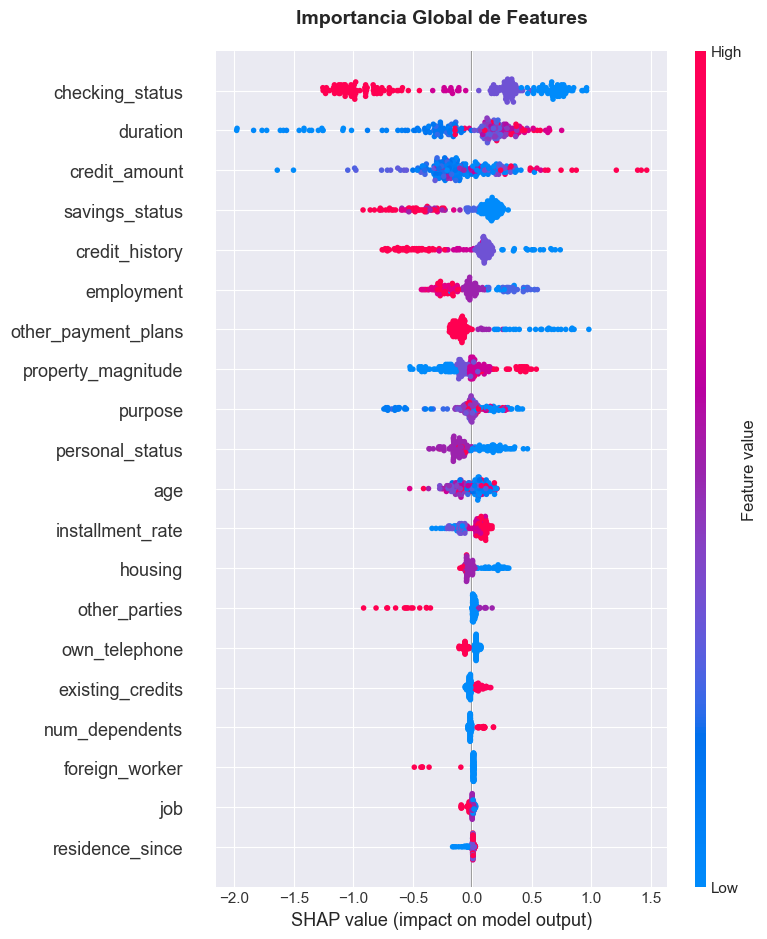

In [20]:
print("\n" + "="*60)
print("📊 SUMMARY PLOT - IMPORTANCIA GLOBAL")
print("="*60)

# Summary plot tipo beeswarm (el más informativo)
shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
plt.title("Importancia Global de Features", fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# ### 📖 Cómo Interpretar el Summary Plot:
# 
# **Eje Y:** Features ordenadas por importancia (arriba = más importante)
# 
# **Eje X:** Impacto en la predicción (SHAP value)
# - Izquierda (negativo) = Disminuye riesgo → Good
# - Derecha (positivo) = Aumenta riesgo → Bad
# 
# **Color de los puntos:**
# - 🔴 Rojo = Valor alto de la feature
# - 🔵 Azul = Valor bajo de la feature
# 
# **Patrones a buscar:**
# - Puntos rojos a la derecha = "Valor alto → Aumenta riesgo"
# - Puntos azules a la izquierda = "Valor bajo → Disminuye riesgo"


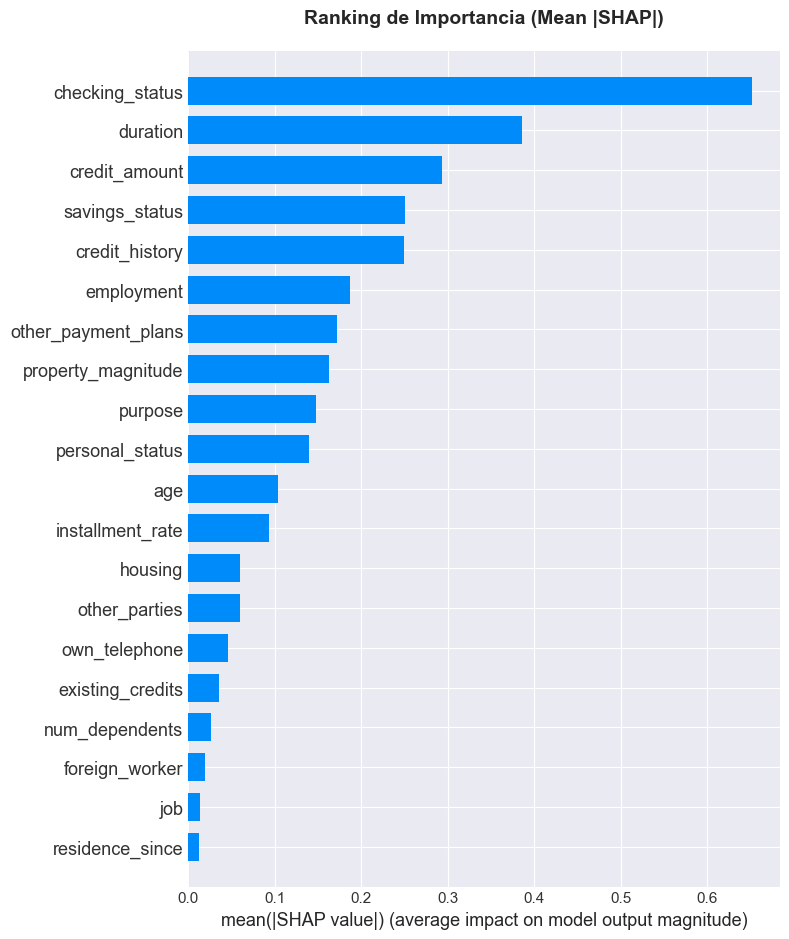


🔝 TOP 10 FEATURES MÁS IMPORTANTES (SHAP):
            feature  importance
    checking_status    0.651367
           duration    0.385341
      credit_amount    0.293579
     savings_status    0.250945
     credit_history    0.249592
         employment    0.186566
other_payment_plans    0.171593
 property_magnitude    0.162857
            purpose    0.147464
    personal_status    0.139388


In [21]:
# Summary plot tipo bar (ranking simple)
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Ranking de Importancia (Mean |SHAP|)", fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Extraer top features más importantes
feature_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False)

print("\n🔝 TOP 10 FEATURES MÁS IMPORTANTES (SHAP):")
print("="*60)
print(feature_importance.head(10).to_string(index=False))

# ## 7. Visualización 3: DEPENDENCE PLOT (Relaciones)
# 
# **¿Qué muestra?**
# - Cómo cambia el impacto de UNA feature según su valor
# - Interacciones con otras features


🔗 DEPENDENCE PLOTS - RELACIONES

Analizando top 3 features:
  1. checking_status
  2. duration
  3. credit_amount


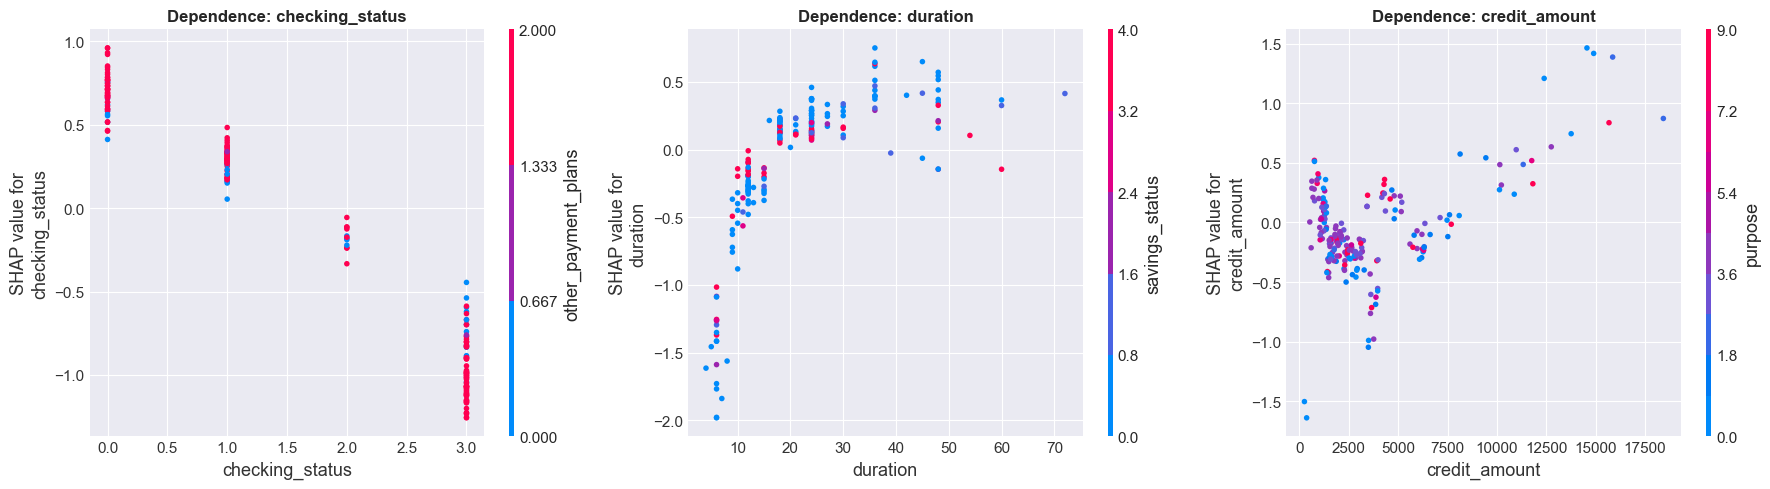

In [22]:
print("\n" + "="*60)
print("🔗 DEPENDENCE PLOTS - RELACIONES")
print("="*60)

# Seleccionar las 3 features más importantes
top_3_features = feature_importance.head(3)['feature'].tolist()

print(f"\nAnalizando top 3 features:")
for i, feat in enumerate(top_3_features, 1):
    print(f"  {i}. {feat}")

# Crear dependence plots para top 3 features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, feature in enumerate(top_3_features):
    plt.sca(axes[idx])
    shap.dependence_plot(
        feature,
        shap_values,
        X_test,
        interaction_index="auto",  # SHAP selecciona automáticamente feature que más interactúa
        ax=axes[idx],
        show=False
    )
    axes[idx].set_title(f'Dependence: {feature}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


# ### 📖 Cómo Interpretar Dependence Plots:
# 
# **Eje X:** Valor de la feature analizada
# 
# **Eje Y:** SHAP value (impacto en predicción)
# - Arriba = Aumenta riesgo
# - Abajo = Disminuye riesgo
# 
# **Color:** Feature con la que más interactúa
# 
# **Patrones:**
# - Línea horizontal = No impacto
# - Línea creciente = A mayor valor, mayor riesgo
# - Línea decreciente = A mayor valor, menor riesgo
# - Curva = Relación no-lineal

# ## 8. Análisis de Casos Específicos
# 
# Vamos a analizar 3 tipos de clientes:
# 1. Cliente correctamente clasificado como Good
# 2. Cliente correctamente clasificado como Bad
# 3. Cliente mal clasificado (error del modelo)

In [23]:
print("\n" + "="*60)
print("🔍 ANÁLISIS DE CASOS ESPECÍFICOS")
print("="*60)

# Obtener predicciones
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Identificar casos
true_positives = np.where((y_test == 1) & (y_pred == 1))[0]
true_negatives = np.where((y_test == 0) & (y_pred == 0))[0]
false_positives = np.where((y_test == 0) & (y_pred == 1))[0]
false_negatives = np.where((y_test == 1) & (y_pred == 0))[0]

print(f"\n📊 Distribución de predicciones:")
print(f"  - True Positives (Bad detectados): {len(true_positives)}")
print(f"  - True Negatives (Good detectados): {len(true_negatives)}")
print(f"  - False Positives (Good → pred Bad): {len(false_positives)}")
print(f"  - False Negatives (Bad → pred Good): {len(false_negatives)}")



🔍 ANÁLISIS DE CASOS ESPECÍFICOS

📊 Distribución de predicciones:
  - True Positives (Bad detectados): 43
  - True Negatives (Good detectados): 113
  - False Positives (Good → pred Bad): 27
  - False Negatives (Bad → pred Good): 17



✅ CASO 1: TRUE NEGATIVE (Good detectado correctamente)
Cliente #87
  Real: Good Risk (0)
  Predicción: Good Risk (0)
  Confianza: 99.3% de ser Good


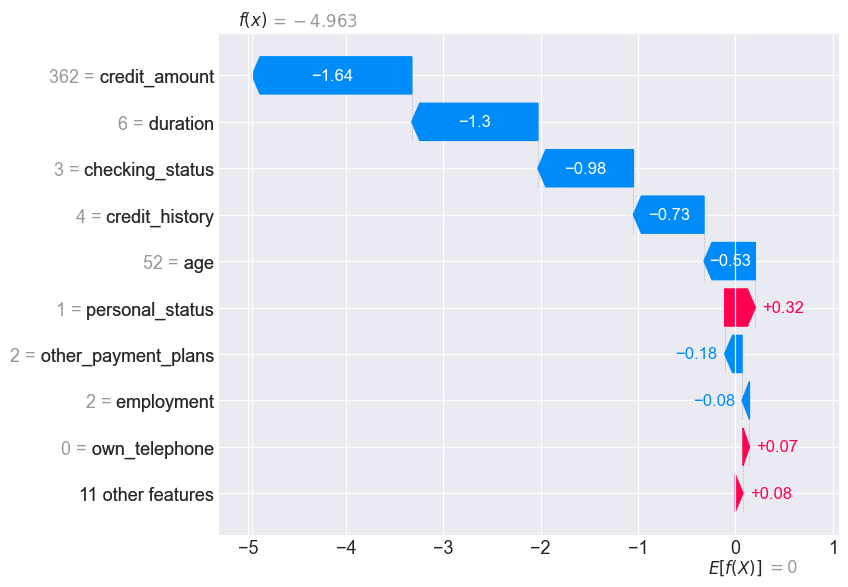

In [24]:
# ### Caso 1: True Negative (Good detectado correctamente)

if len(true_negatives) > 0:
    # Seleccionar un TN con alta confianza
    tn_idx = true_negatives[np.argmin(y_pred_proba[true_negatives])]
    
    print(f"\n{'='*60}")
    print("✅ CASO 1: TRUE NEGATIVE (Good detectado correctamente)")
    print(f"{'='*60}")
    print(f"Cliente #{tn_idx}")
    print(f"  Real: Good Risk (0)")
    print(f"  Predicción: Good Risk (0)")
    print(f"  Confianza: {(1-y_pred_proba[tn_idx])*100:.1f}% de ser Good")
    
    # Waterfall plot
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values[tn_idx],
            base_values=explainer.expected_value,
            data=X_test.iloc[tn_idx],
            feature_names=X_test.columns.tolist()
        )
    )



✅ CASO 2: TRUE POSITIVE (Bad detectado correctamente)
Cliente #195
  Real: Bad Risk (1)
  Predicción: Bad Risk (1)
  Confianza: 95.0% de ser Bad


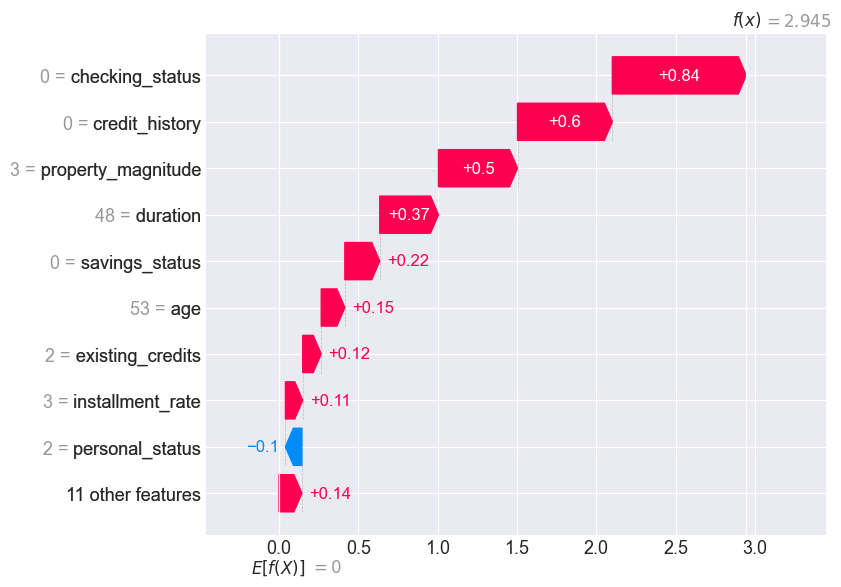

In [25]:
# ### Caso 2: True Positive (Bad detectado correctamente)

if len(true_positives) > 0:
    # Seleccionar un TP con alta confianza
    tp_idx = true_positives[np.argmax(y_pred_proba[true_positives])]
    
    print(f"\n{'='*60}")
    print("✅ CASO 2: TRUE POSITIVE (Bad detectado correctamente)")
    print(f"{'='*60}")
    print(f"Cliente #{tp_idx}")
    print(f"  Real: Bad Risk (1)")
    print(f"  Predicción: Bad Risk (1)")
    print(f"  Confianza: {y_pred_proba[tp_idx]*100:.1f}% de ser Bad")
    
    # Waterfall plot
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values[tp_idx],
            base_values=explainer.expected_value,
            data=X_test.iloc[tp_idx],
            feature_names=X_test.columns.tolist()
        )
    )



❌ CASO 3: FALSE NEGATIVE (Bad clasificado como Good)
Cliente #4
  Real: Bad Risk (1) ⚠️
  Predicción: Good Risk (0) ❌
  Probabilidad de Bad: 28.9%

💡 Este es un ERROR CRÍTICO: Aprobamos un mal cliente


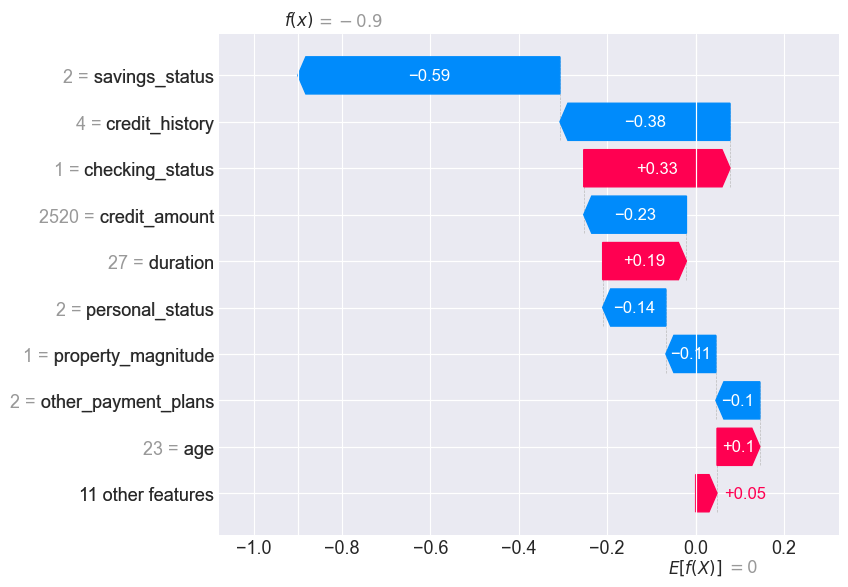


🔍 Análisis del error:
  - ¿Qué features empujaron INCORRECTAMENTE hacia Good?
  - ¿Había señales de riesgo que el modelo ignoró?


In [26]:
# ### Caso 3: False Negative (Bad clasificado como Good - ERROR CRÍTICO)

if len(false_negatives) > 0:
    # Seleccionar un FN (estos son los errores más costosos)
    fn_idx = false_negatives[0]
    
    print(f"\n{'='*60}")
    print("❌ CASO 3: FALSE NEGATIVE (Bad clasificado como Good)")
    print(f"{'='*60}")
    print(f"Cliente #{fn_idx}")
    print(f"  Real: Bad Risk (1) ⚠️")
    print(f"  Predicción: Good Risk (0) ❌")
    print(f"  Probabilidad de Bad: {y_pred_proba[fn_idx]*100:.1f}%")
    print(f"\n💡 Este es un ERROR CRÍTICO: Aprobamos un mal cliente")
    
    # Waterfall plot
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values[fn_idx],
            base_values=explainer.expected_value,
            data=X_test.iloc[fn_idx],
            feature_names=X_test.columns.tolist()
        )
    )
    
    print("\n🔍 Análisis del error:")
    print("  - ¿Qué features empujaron INCORRECTAMENTE hacia Good?")
    print("  - ¿Había señales de riesgo que el modelo ignoró?")


In [27]:
# Análisis que podrías hacer:
for fn in false_negatives:
    print(f"Cliente {fn}:")
    print(f"  - savings_status: {X_test.iloc[fn]['savings_status']}")
    print(f"  - credit_history: {X_test.iloc[fn]['credit_history']}")
    print(f"  - age: {X_test.iloc[fn]['age']}")

Cliente 4:
  - savings_status: 2
  - credit_history: 4
  - age: 23
Cliente 11:
  - savings_status: 0
  - credit_history: 4
  - age: 43
Cliente 13:
  - savings_status: 0
  - credit_history: 2
  - age: 21
Cliente 22:
  - savings_status: 0
  - credit_history: 4
  - age: 42
Cliente 49:
  - savings_status: 4
  - credit_history: 2
  - age: 25
Cliente 55:
  - savings_status: 4
  - credit_history: 2
  - age: 51
Cliente 60:
  - savings_status: 0
  - credit_history: 2
  - age: 28
Cliente 64:
  - savings_status: 2
  - credit_history: 2
  - age: 26
Cliente 77:
  - savings_status: 0
  - credit_history: 2
  - age: 22
Cliente 94:
  - savings_status: 0
  - credit_history: 2
  - age: 24
Cliente 109:
  - savings_status: 0
  - credit_history: 4
  - age: 31
Cliente 110:
  - savings_status: 2
  - credit_history: 4
  - age: 44
Cliente 111:
  - savings_status: 3
  - credit_history: 2
  - age: 54
Cliente 121:
  - savings_status: 0
  - credit_history: 4
  - age: 29
Cliente 134:
  - savings_status: 4
  - credit

# Podria concluir con que los 2 parametros que mas afectac al sesgo son savings_status y credit_history


💪 FORCE PLOT - VISUALIZACIÓN INTERACTIVA


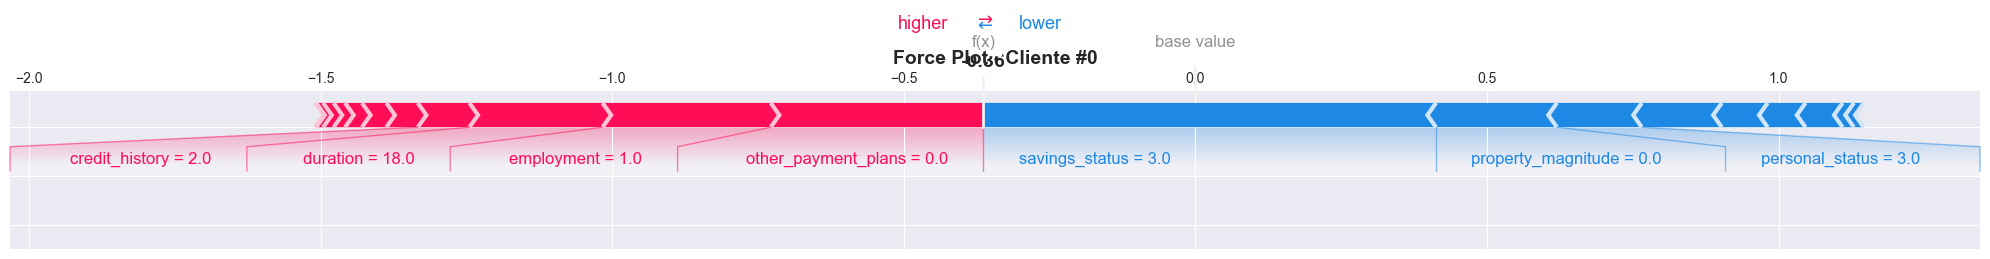


💡 Interpretación Force Plot:
  - Rojo: Features que empujan hacia Bad (aumentan riesgo)
  - Azul: Features que empujan hacia Good (disminuyen riesgo)
  - Ancho de la barra = magnitud del impacto


In [32]:
# ## 9. Force Plot (Visualización Alternativa)

print("\n" + "="*60)
print("💪 FORCE PLOT - VISUALIZACIÓN INTERACTIVA")
print("="*60)

# Force plot para un cliente
sample_idx = 0

shap.force_plot(
    explainer.expected_value,
    shap_values[sample_idx],
    X_test.iloc[sample_idx],
    matplotlib=True,
    show=False
)
plt.title(f"Force Plot - Cliente #{sample_idx}", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 Interpretación Force Plot:")
print("  - Rojo: Features que empujan hacia Bad (aumentan riesgo)")
print("  - Azul: Features que empujan hacia Good (disminuyen riesgo)")
print("  - Ancho de la barra = magnitud del impacto")



⚖️ COMPARACIÓN: SHAP vs XGBoost Feature Importance

TOP 10 Features - Comparación:
            feature  xgb_norm  shap_norm
    checking_status  0.194410   0.209572
 property_magnitude  0.067393   0.052398
     savings_status  0.066304   0.080739
other_payment_plans  0.062187   0.055209
     credit_history  0.061148   0.080304
           duration  0.052625   0.123980
         employment  0.049692   0.060026
      own_telephone  0.048168   0.014806
    residence_since  0.045642   0.004129
   existing_credits  0.042413   0.011474


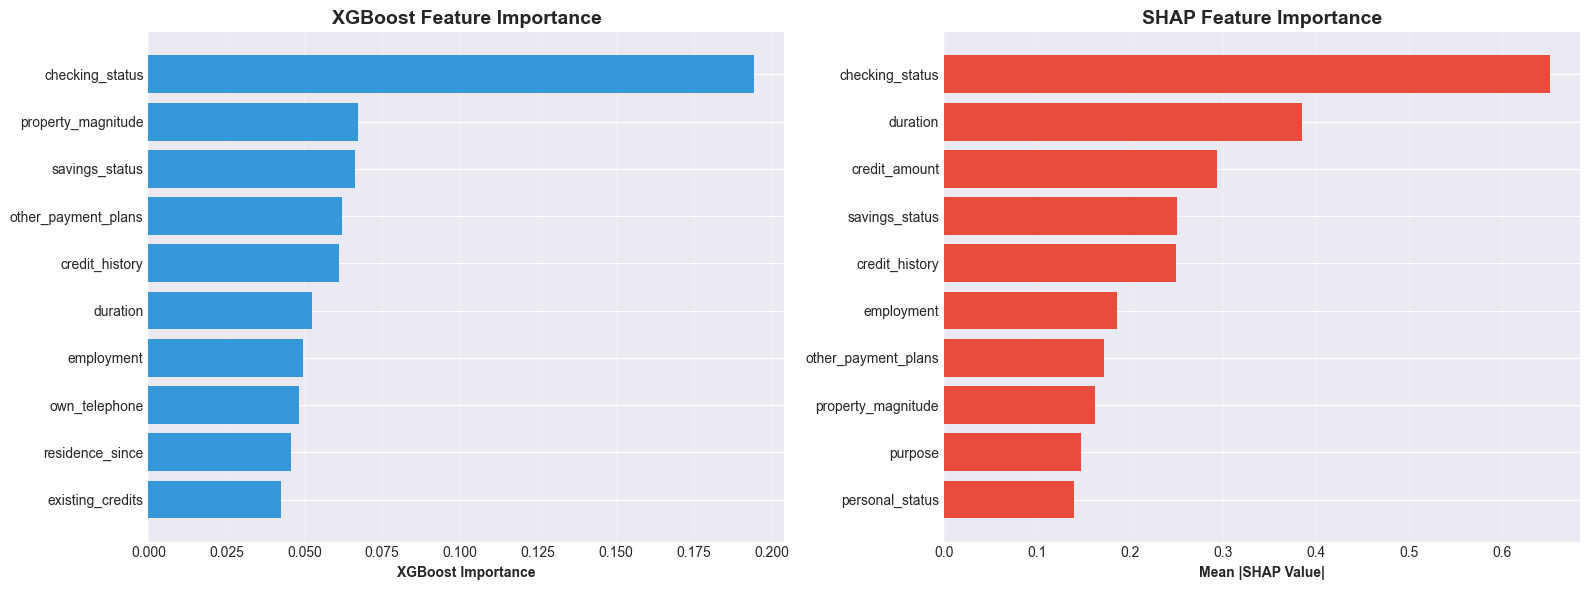


💡 Diferencias clave:
  - XGBoost Importance: Basada en splits (qué features usa más)
  - SHAP: Basada en impacto real en predicciones (cuánto aporta cada feature)


In [29]:
# ## 10. Comparación: SHAP vs Feature Importance de XGBoost

print("\n" + "="*60)
print("⚖️ COMPARACIÓN: SHAP vs XGBoost Feature Importance")
print("="*60)

# Feature importance de XGBoost
xgb_importance = pd.DataFrame({
    'feature': X_test.columns,
    'xgb_importance': model.feature_importances_
}).sort_values('xgb_importance', ascending=False)

# SHAP importance (ya calculada antes)
shap_importance = feature_importance.copy()
shap_importance.columns = ['feature', 'shap_importance']

# Merge
comparison = pd.merge(xgb_importance, shap_importance, on='feature')

# Normalizar para comparar
comparison['xgb_norm'] = comparison['xgb_importance'] / comparison['xgb_importance'].sum()
comparison['shap_norm'] = comparison['shap_importance'] / comparison['shap_importance'].sum()

print("\nTOP 10 Features - Comparación:")
print("="*60)
print(comparison.head(10)[['feature', 'xgb_norm', 'shap_norm']].to_string(index=False))

# %%
# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# XGBoost Importance
top_10_xgb = comparison.head(10)
axes[0].barh(range(10), top_10_xgb['xgb_importance'].values, color='#3498db')
axes[0].set_yticks(range(10))
axes[0].set_yticklabels(top_10_xgb['feature'].values)
axes[0].set_xlabel('XGBoost Importance', fontweight='bold')
axes[0].set_title('XGBoost Feature Importance', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# SHAP Importance
top_10_shap = comparison.sort_values('shap_importance', ascending=False).head(10)
axes[1].barh(range(10), top_10_shap['shap_importance'].values, color='#e74c3c')
axes[1].set_yticks(range(10))
axes[1].set_yticklabels(top_10_shap['feature'].values)
axes[1].set_xlabel('Mean |SHAP Value|', fontweight='bold')
axes[1].set_title('SHAP Feature Importance', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Diferencias clave:")
print("  - XGBoost Importance: Basada en splits (qué features usa más)")
print("  - SHAP: Basada en impacto real en predicciones (cuánto aporta cada feature)")


In [30]:
# ## 11. Guardar Explainer y SHAP Values

print("\n" + "="*60)
print("💾 GUARDANDO ARTEFACTOS")
print("="*60)

models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

# Guardar explainer
explainer_path = models_dir / 'shap_explainer.pkl'
joblib.dump(explainer, explainer_path)
print(f"✅ Explainer guardado: {explainer_path}")

# Guardar SHAP values del test set
shap_values_path = models_dir / 'shap_values_test.pkl'
joblib.dump(shap_values, shap_values_path)
print(f"✅ SHAP values guardados: {shap_values_path}")

# Guardar feature importance
importance_path = models_dir / 'shap_feature_importance.csv'
feature_importance.to_csv(importance_path, index=False)
print(f"✅ Feature importance guardado: {importance_path}")


💾 GUARDANDO ARTEFACTOS
✅ Explainer guardado: ..\models\shap_explainer.pkl
✅ SHAP values guardados: ..\models\shap_values_test.pkl
✅ Feature importance guardado: ..\models\shap_feature_importance.csv


In [33]:
# ## 12. Resumen y Conclusiones

print("\n" + "="*60)
print("📝 RESUMEN EJECUTIVO - INTERPRETABILIDAD")
print("="*60)

top_3 = feature_importance.head(3)

print(f"""
✅ ANÁLISIS SHAP COMPLETADO

📊 TOP 3 FEATURES MÁS IMPORTANTES:
   1. {top_3.iloc[0]['feature']}: {top_3.iloc[0]['importance']:.4f}
   2. {top_3.iloc[1]['feature']}: {top_3.iloc[1]['importance']:.4f}
   3. {top_3.iloc[2]['feature']}: {top_3.iloc[2]['importance']:.4f}

🔍 CAPACIDAD DE EXPLICACIÓN:
   - ✅ Explicaciones individuales (Waterfall)
   - ✅ Importancia global (Summary)
   - ✅ Relaciones no-lineales (Dependence)
   - ✅ Casos específicos analizados

💾 ARTEFACTOS GUARDADOS:
   - shap_explainer.pkl
   - shap_values_test.pkl
   - shap_feature_importance.csv

🎯 PRÓXIMOS PASOS:
   1. Documentar insights en LEARNINGS.md
   2. Crear dashboard interactivo con Streamlit
   3. Integrar explicaciones SHAP en la interfaz
""")

print("✅ Análisis de interpretabilidad completado exitosamente")
print("📁 Listo para siguiente fase: Dashboard")


📝 RESUMEN EJECUTIVO - INTERPRETABILIDAD

✅ ANÁLISIS SHAP COMPLETADO

📊 TOP 3 FEATURES MÁS IMPORTANTES:
   1. checking_status: 0.6514
   2. duration: 0.3853
   3. credit_amount: 0.2936

🔍 CAPACIDAD DE EXPLICACIÓN:
   - ✅ Explicaciones individuales (Waterfall)
   - ✅ Importancia global (Summary)
   - ✅ Relaciones no-lineales (Dependence)
   - ✅ Casos específicos analizados

💾 ARTEFACTOS GUARDADOS:
   - shap_explainer.pkl
   - shap_values_test.pkl
   - shap_feature_importance.csv

🎯 PRÓXIMOS PASOS:
   1. Documentar insights en LEARNINGS.md
   2. Crear dashboard interactivo con Streamlit
   3. Integrar explicaciones SHAP en la interfaz

✅ Análisis de interpretabilidad completado exitosamente
📁 Listo para siguiente fase: Dashboard
